# German Credit dataset

## Contents

4. Build a baseline model
5. Prepare the data to better expose the underlying patterns to machine learning algorithm (incl feature engineering)
6. Explore many modesl; Select a model and train it
7. Fine-tune the model
8. Present your solution
9. Deploy, monitor and maintain your system



##### TODO
- tenure/age
- Ensemble model?
- Deploy



<br>

### Imports

In [1]:
# imports from Python Standard Library
import re, warnings

from collections import Counter
from statistics import mean

In [2]:
# Third party imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [3]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [4]:
# sklearn imports
from sklearn.metrics import (accuracy_score, recall_score, precision_score, fbeta_score, roc_auc_score, classification_report)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import NotFittedError


In [5]:
# Custom utilities
from src.helper_utilities import load_data
from src.modeling_utilities import Baseline, classification_scores, f2
from src.plotting_utilities import plot_probabilities_distributions

In [6]:
# Settings
#warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

### Random Seed

In [7]:
SEED = 42

### Load the data

In [8]:
# Get the (user-friendly) data for a baseline model
df = load_data(mode='analysis', format='dataframe')

# Save the "user friendly" dataframe for EDA as csv
df.to_csv("data/user_friendly_cats.csv", index=False)

# get the data from the saved csv due to the pd quirk with Ctegoricals
df = pd.read_csv("data/user_friendly_cats.csv")
df.head()


,tenure,amount,rate,residence,age,credits,maintenance,history,savings,employment,...,status,purpose,guarantor,installments,housing,telephone,foreign,sex,personal,label
0,6,1169,4,4,67,2,1,critical,no savings,"[7, inf)",...,overdrawn,television,none,none,ownership,yes,True,male,male single,0
1,48,5951,2,2,22,1,1,so far so good,"[0, 100)","[1, 4)",...,petty,television,none,none,ownership,none,True,female,female divorced/separated/married,1
2,12,2096,2,3,49,1,2,critical,"[0, 100)","[4, 7)",...,no account,education,none,none,ownership,none,True,male,male single,0
3,42,7882,2,4,45,1,2,so far so good,"[0, 100)","[4, 7)",...,overdrawn,furniture,guarantor,none,without payment,none,True,male,male single,0
4,24,4870,3,4,53,2,2,delay,"[0, 100)","[1, 4)",...,overdrawn,car,none,none,without payment,none,True,male,male single,1


# 4. Baseline model

This baseline model is based on a simple lookup table approach. You can view the code here:
[src/modeling_utilities.py](src/modeling_utilities.py)

In [9]:
# Train Test Split
X = df.copy()
y = X.pop('label')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [10]:
# This baseline model is based on a simple lookup table approach
baseline = Baseline(best_features=['status', 'history', 'savings'], threshold=0.5)
baseline.fit(X_train, y_train)

Baseline(best_features=['status', 'history', 'savings'], threshold=0.5)

In [11]:
# Cross validation F2 score (on the whole dataset; with the default threshold of 0.5)
print("F2 =", cross_val_score(baseline, X_train, y_train, scoring=f2, cv=10).mean().round(2))

F2 = 0.5


In [12]:
# The default threshold of 0.5 givs us the following results on the test set:
y_pred = baseline.predict(X_test)
classification_scores(y_test, y_pred)

accuracy     0.72
precision    0.55
recall       0.47
f1           0.50
f2           0.48
dtype: float64

In [13]:
# AUC
y_score = baseline.predict_proba(X_test)
print("AUC =", roc_auc_score(y_test, y_score).round(2))

AUC = 0.72


In [14]:
# Hyperparameter grid search: the best model's threshold is 0.125 and has the F2 = 0.71
gs = GridSearchCV(baseline, {'threshold': np.linspace(0.05, 0.2, num=7)}, cv=10, scoring=f2).fit(X_train, y_train)
print("threshold =", round(gs.best_estimator_.threshold, 3), "\tF2 =", gs.best_score_.round(2))

threshold = 0.075 	F2 = 0.68


So, the goal is to beat the F2-score (and possibly the AUC)

<br>

# 5. Data Preprocessing

### Note how the features are ordered in the original dataset

In [15]:
# View the attribute names from the info document
path = 'data/german.doc'

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print('\033[91m{}\033[0m'.format("Column index,"),  "original feature name and", '\033[92m{}\033[0m'.format("my short name"), end="\n\n")

# make a mapping from the "handy" name to the actual column index
column_index = dict()

for m in re.finditer(pattern, text):
    possible_names = [s for s in df.columns for pattern in (fr"\b{s}\b", fr"\b{s[:-1]}")
                      if re.search(pattern, m.groupdict()['name'], re.IGNORECASE)] or ['tenure']
    my_column_name = Counter(sorted(possible_names)).most_common(1)[0][0]
    print('\033[91m{}\033[0m'.format(int(m.groupdict()['attr'])-1), f"{m.groupdict()['name'].strip()}", '\033[92m({})\033[0m'.format(my_column_name))
    column_index[my_column_name] = int(m.groupdict()['attr'])-1


Column index, original feature name and my short name

0 Status of existing checking account (status)
1 Duration in month (tenure)
2 Credit history (history)
3 Purpose (purpose)
4 Credit amount (amount)
5 Savings account/bonds (savings)
6 Present employment since (employment)
7 Installment rate in percentage of disposable income (rate)
8 Personal status and sex (personal)
9 Other debtors / guarantors (guarantor)
10 Present residence since (residence)
11 Property (property)
12 Age in years (age)
13 Other installment plans (installments)
14 Housing (housing)
15 Number of existing credits at this bank (credits)
16 Job (job)
17 Number of people being liable to provide maintenance for (maintenance)
18 Telephone (telephone)
19 foreign worker (foreign)


### Load the original dataset

Q: Which format to expect as input into our pipeline?

A: We'll opt for DataFrame because we will want to determine feature data types dynamically with pandas' functionality.

In [16]:
# load the original dataset as df
X, y = load_data(mode='modeling', format='dataframe')

### Train Test Split

Because we do not want to touch the test set and we do not want any information leakage from the val set, we will split the dataset as follows. It might seem superfluous, but these splits will be needed:

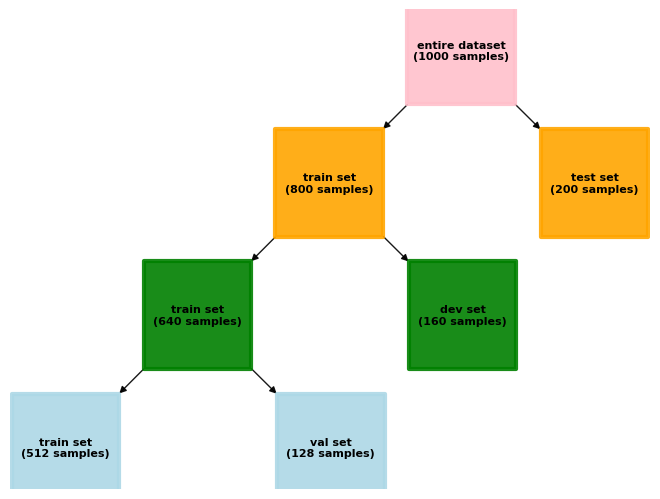

In [17]:
G = nx.DiGraph()  # with arrows

# Add nodes
G.add_node(0, label="entire dataset\n(1000 samples)", color='pink')
G.add_node(1, label="train set\n(800 samples)", color='orange')
G.add_node(2, label="test set\n(200 samples)", color='orange')
G.add_node(3, label="train set\n(640 samples)", color='green')
G.add_node(4, label="dev set\n(160 samples)", color='green')
G.add_node(5, label="train set\n(512 samples)", color='lightblue')
G.add_node(6, label="val set\n(128 samples)", color='lightblue')

# Add edges
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)
G.add_edge(3, 5)
G.add_edge(3, 6)

pos = graphviz_layout(G, prog="dot")

labels = nx.get_node_attributes(G, "label")
colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=False, 
                arrows=True,
                node_shape="s",    # so^>v<dph8
                node_size=6000, 
                node_color=colors, 
                font_color='k',
                edge_color="k", 
                linewidths=3, 
                font_weight="bold", 
                alpha=0.9)

nx.draw_networkx_labels(G, pos, labels=labels, 
                                font_color="black", 
                                font_size=8, 
                                font_weight="bold")
plt.axis('off')  # Turn off axis
plt.savefig("assets/graph.png")  # Save as PNG

In [18]:
# the "orange" dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

# the "green" dataset
X_train_dev, X_dev, y_train_dev, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# the "blue" dataset (might be needed for LightGBM)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=SEED)
X_test[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
30,A12,18,A32,A49,1913,A64,A72,3,A94,A101,3,A121,36,A141,A152,1,A173,1,A192,A201
128,A12,12,A34,A41,1860,A61,A71,4,A93,A101,2,A123,34,A143,A152,2,A174,1,A192,A201
289,A11,24,A33,A43,1024,A61,A72,4,A94,A101,4,A121,48,A142,A152,1,A173,1,A191,A201


### Determine the features which may be excluded from our model

According to our statistical tests earlier these features are useless: ['residence', 'job', 'credits', 'telephone', 'maintenance']

In [19]:
# sorted bad to worst
weak_features = ['residence', 'job', 'credits', 'telephone', 'maintenance']
features_to_keep = sorted(set(range(X.shape[1])) - set(column_index[k] for k in weak_features))
features_to_keep

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 19]

# Shortlist promissing models

Quick and dirty models:
- logistic regression (L1)
- naive bayes
- tree / random forest
- gradient boosting
- support vector machine
- neural network

metric: F2

In [20]:
# collect metrics 
collector = dict()

input_features = sorted(column_index.keys(), key=lambda k: column_index[k])

In [21]:
# Logistic Regression

lr = make_pipeline(
        ColumnTransformer([
                ("ratio", FunctionTransformer(lambda df: (df.iloc[:, 0] / df.iloc[:, 1]).values.reshape(-1,1),
                            feature_names_out=lambda self, feature_names_in: ["ratio"]), [1, 12]),
                ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
                ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=['category', object]))
                        ], 
                        remainder='passthrough'),
        LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=SEED)
)

collector["logistic regression"] = cross_val_score(lr, X_train, y_train, scoring=f2, cv=10)

In [22]:
# Naive Bayes

# Gaussian NB
pl_num = make_pipeline(
    ColumnTransformer([("num_log", FunctionTransformer(np.log, inverse_func=np.exp), make_column_selector(dtype_include=np.number))], remainder='drop'), 
    GaussianNB()
    )

# Categorical NB
pl_cat = nb = make_pipeline(
    ColumnTransformer([("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=['category', 'object']))], remainder='drop'), 
    CategoricalNB()
    )

# Ensemble NB
vc = VotingClassifier(estimators=[("num", pl_num), ("cat", pl_cat)], voting='soft', weights=(0.5, 0.5))

collector["naive bayes (categorical)"] = cross_val_score(nb, X_train, y_train, scoring=f2, cv=10)
collector["naive bayes (soft voting)"] = cross_val_score(vc, X_train, y_train, scoring=f2, cv=10)


In [23]:
# Decision Tree / Random Forest
ct = ColumnTransformer([
                ("num", 'passthrough', make_column_selector(dtype_include=np.number)),
                ("cat", OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=['category', object]))
                        ], 
        remainder='passthrough')

dt = make_pipeline(ct, DecisionTreeClassifier(random_state=SEED))
rf = make_pipeline(ct, RandomForestClassifier(random_state=SEED))

collector["decision tree"] = cross_val_score(dt, X_train, y_train, scoring=f2, cv=10)
collector["random forest"] = cross_val_score(rf, X_train, y_train, scoring=f2, cv=10)


In [24]:
# Gradient Boosting

gb = make_pipeline(
    ColumnTransformer([
            ("num", 'passthrough', make_column_selector(dtype_include=np.number)),
            ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=['category', object]))
                    ], 
            remainder='passthrough'),
    LGBMClassifier(objective='binary', random_state=SEED)
)

#workaround
gb[0].fit(X_train, y_train)

params = {f"{gb.steps[-1][0]}__categorical_feature": list(range(len(X_train.select_dtypes(include=np.number).columns), X_train.shape[1])),
          f"{gb.steps[-1][0]}__feature_name": list(gb[0].get_feature_names_out(input_features=input_features))}

collector["gradient boosting"] = cross_val_score(gb, X_train, y_train, scoring=f2, cv=10, params=params)

[LightGBM] [Info] Number of positive: 216, number of negative: 504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [25]:
# SVC
sv = make_pipeline(
        ColumnTransformer([
                ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
                ("cat", OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=['category', object]))
                ], 
                remainder='passthrough'),
        SVC(probability=True, random_state=SEED)
)

collector["support vector"] = cross_val_score(sv, X_train, y_train, scoring=f2, cv=10)

In [26]:
# ANN
nn = make_pipeline(
        ColumnTransformer([
                ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
                ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=['category', object]))
                        ], 
                remainder='passthrough'),
        MLPClassifier(hidden_layer_sizes=(128, 128, 64), random_state=SEED)
)

collector["neural network"] = cross_val_score(nn, X_train, y_train, scoring=f2, cv=10)

In [27]:
# Print the summary
df_f2 = pd.DataFrame([
    {k:mean(v) for k,v in collector.items()}, 
    {k:np.std(v) for k,v in collector.items()},
    ], index=["mean_f2", "std_f2"]).T.sort_values('mean_f2', ascending=False).round(2)

df_f2

,mean_f2,std_f2
decision tree,0.52,0.08
naive bayes (categorical),0.50,0.12
neural network,0.48,0.12
gradient boosting,0.47,0.10
logistic regression,0.46,0.09
random forest,0.41,0.10
support vector,0.41,0.07
naive bayes (soft voting),0.34,0.09


### Analyze feature importance

In [28]:
# Feature importances according to the logistic regression model
lr.fit(X_train, y_train)
sr = pd.Series(lr[-1].coef_.ravel(), index=lr[:-1].get_feature_names_out(input_features=input_features)).sort_values(key=abs, ascending=False)
print("top most important features in the logistic model:")
sr.head(15)

top most important features in the logistic model:


cat__status_A14          -1.493327
cat__savings_A64         -1.090630
cat__purpose_A41         -1.012497
cat__savings_A65         -0.945300
cat__property_A124        0.906691
cat__history_A34         -0.851392
ratio__ratio              0.835143
cat__foreign_A202        -0.823896
cat__housing_A153        -0.801168
cat__installments_A143   -0.657850
cat__purpose_A43         -0.587659
cat__status_A13          -0.565111
cat__personal_A93        -0.552354
cat__employment_A74      -0.511346
cat__purpose_A46          0.496311
dtype: float64

In [29]:
print("least important features in the logistic model:")
sr.tail(10)

least important features in the logistic model:


cat__history_A32      -0.027509
num__tenure            0.023709
num__residence         0.008622
cat__purpose_A48       0.000000
cat__job_A174          0.000000
cat__personal_A92      0.000000
cat__job_A172          0.000000
cat__purpose_A44       0.000000
cat__employment_A75    0.000000
cat__purpose_A45       0.000000
dtype: float64

In [30]:
# Feature importances according to the tree model
dt.fit(X_train, y_train)
sr = pd.Series(dt.steps[1][1].feature_importances_, index=dt[:-1].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


num__amount            0.164725
cat__status_A14        0.100449
num__tenure            0.098057
num__rate              0.060340
num__age               0.045220
num__residence         0.037368
cat__purpose_A42       0.030838
cat__employment_A73    0.027211
cat__employment_A72    0.023570
cat__purpose_A46       0.023185
dtype: float64

In [31]:
print("least important features in the tree model:")
sr.tail(10)

least important features in the tree model:


cat__job_A174             0.0
cat__job_A171             0.0
cat__purpose_A44          0.0
cat__housing_A151         0.0
cat__installments_A142    0.0
cat__guarantor_A103       0.0
cat__savings_A65          0.0
cat__purpose_A410         0.0
cat__purpose_A48          0.0
cat__foreign_A202         0.0
dtype: float64

In [32]:
# Feature importances according to the random forest model
rf.fit(X_train, y_train)
sr = pd.Series(rf.steps[1][1].feature_importances_, index=rf[:-1].get_feature_names_out(input_features=input_features)).sort_values(ascending=False)
print("top most important features in the tree model:")
sr.head(10)

top most important features in the tree model:


num__amount            0.097306
num__age               0.077475
num__tenure            0.076896
cat__status_A14        0.055298
num__rate              0.037191
cat__status_A11        0.032267
num__residence         0.031314
cat__history_A34       0.022410
cat__savings_A61       0.020945
cat__employment_A72    0.019524
dtype: float64

In [33]:
print("least important features in the random forest model:")
sr.tail(10)

least important features in the random forest model:


cat__personal_A94         0.007131
cat__installments_A142    0.007075
cat__savings_A63          0.005510
cat__savings_A64          0.005245
cat__purpose_A45          0.003938
cat__foreign_A202         0.003130
cat__job_A171             0.003069
cat__purpose_A44          0.001636
cat__purpose_A410         0.001352
cat__purpose_A48          0.000893
dtype: float64

[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

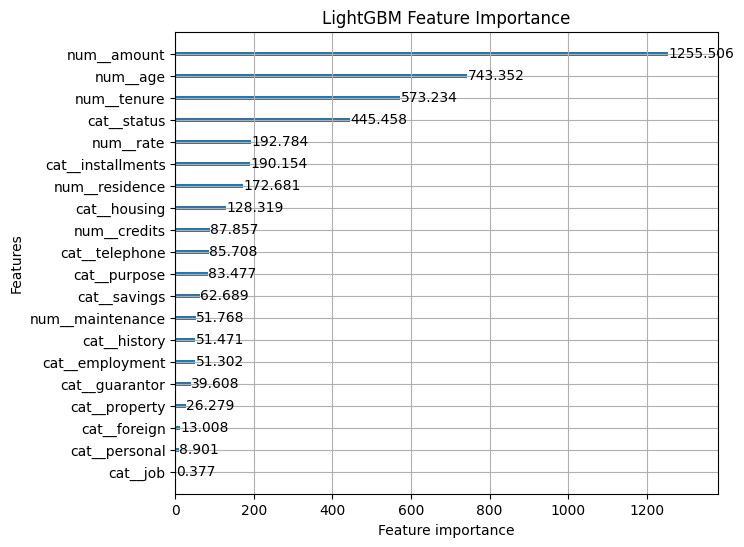

In [34]:
# Feature importances according to the gradient boosting model

params = {f"{gb.steps[-1][0]}__categorical_feature": list(range(len(X_train.select_dtypes(include=np.number).columns), X_train.shape[1])),
          f"{gb.steps[-1][0]}__feature_name": list(gb[0].get_feature_names_out(input_features=input_features))}
gb.fit(X_train, y_train, **params)
lgb.plot_importance(gb.steps[-1][1], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance");

### Analysis of how certain the models are about their predictions

The following distributions of predicted probabilities show that the most certain models are the neural network, decision tree, followed by gradient boosting

[LightGBM] [Info] Number of positive: 195, number of negative: 445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304688 -> initscore=-0.825075
[LightGBM] [Info] Start training from score -0.825075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

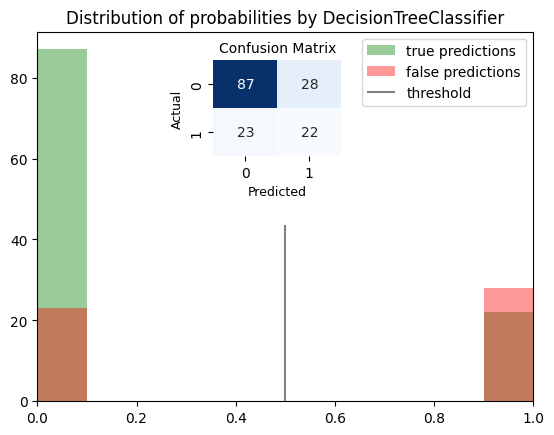

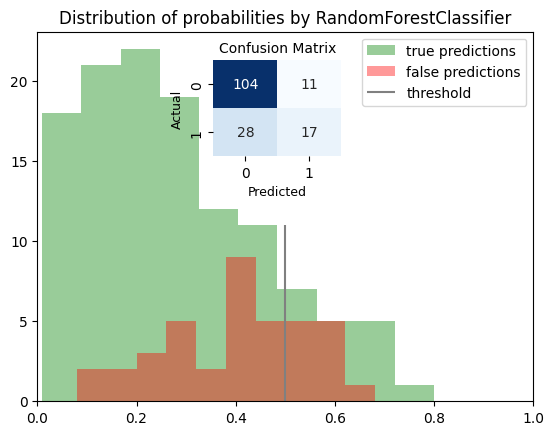

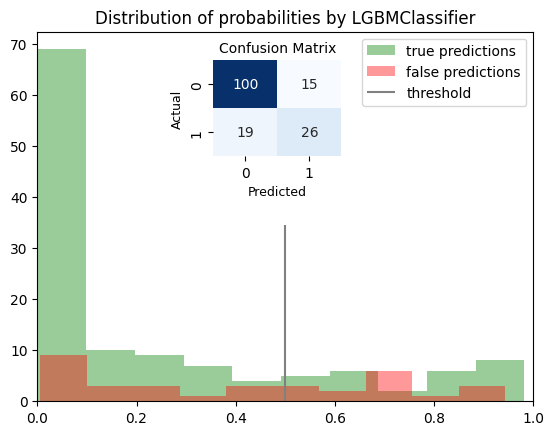

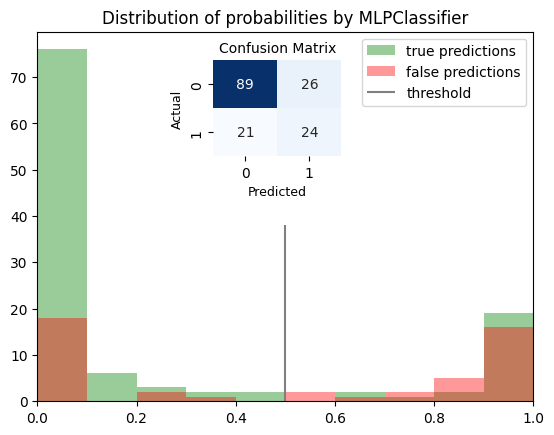

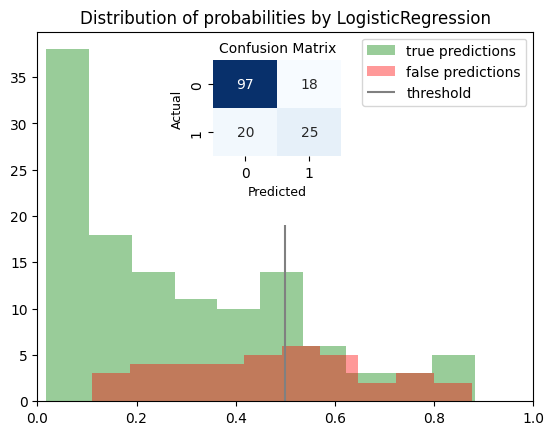

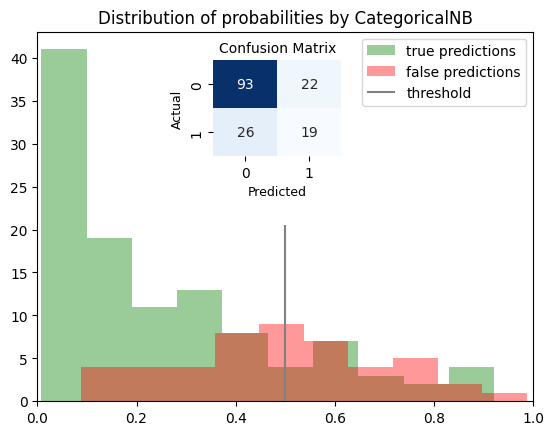

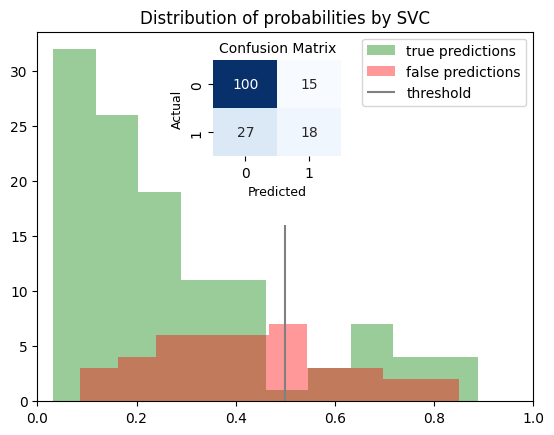

In [35]:
# View the distributions of predictions
models = [dt, rf, gb, nn,  lr, nb, sv]

for model in models:
    fig = plt.figure()
    model.fit(X_train_dev, y_train_dev)
    plot_probabilities_distributions(model, X_dev, y_dev, n_bins=10, alpha=0.4)

### Here is a good place to have a look at the AUC's of each model

note: ideally a dev set should be used here, but instead we simply use the whole dataset as an exception

In [36]:
df_f2["AUC"] = pd.Series({
    "logistic regression": roc_auc_score(y_dev, lr.predict_proba(X_dev)[:,-1]),
    "naive bayes (categorical)": roc_auc_score(y_dev, nb.predict_proba(X_dev)[:,-1]),
    "decision tree": roc_auc_score(y_dev, dt.predict_proba(X_dev)[:,-1]),
    "random forest": roc_auc_score(y_dev, rf.predict_proba(X_dev)[:,-1]),
    "neural network": roc_auc_score(y_dev, nn.predict_proba(X_dev)[:,-1]),
    "support vector": roc_auc_score(y_dev, sv.predict_proba(X_dev)[:,-1]),
    "gradient boosting": roc_auc_score(y_dev, gb.predict_proba(X_dev)[:,-1]),
})

df_f2.sort_values(['AUC', 'mean_f2'], ascending=[False, False]).round(2).drop('std_f2', axis=1).rename(columns={'mean_f2': "f2"})


,f2,AUC
gradient boosting,0.47,0.81
logistic regression,0.46,0.80
random forest,0.41,0.79
support vector,0.41,0.78
naive bayes (categorical),0.50,0.77
neural network,0.48,0.72
decision tree,0.52,0.62
naive bayes (soft voting),0.34,NaN


??? Based on the f2-scores and the AUC's the shortlisted models are:
- decision tree / random forest
- gradient boosting
- neural network

<br>

# Error Analysis

View confusion matreces


<br>

ChatGPT:

Performing an error analysis is an essential step in understanding a model's performance and the types of errors it makes. Here are steps to perform an error analysis:
1. Collect Predictions and True Labels

    Start with your model's predictions on a validation or test set.
    Collect the true labels corresponding to these predictions.

2. Confusion Matrix

    Construct a confusion matrix. This is particularly useful for classification tasks.
    For each class, the confusion matrix shows how many samples were correctly classified and how many were misclassified into other classes.
    This helps in understanding which classes are often confused with each other.

3. Calculate Metrics

    Calculate standard evaluation metrics like accuracy, precision, recall, and F1-score.
    These metrics provide an overall view of the model's performance but can be limited in understanding specific errors.

4. Analyze Misclassifications

    Look at individual samples that were misclassified.
    Examine the features, context, or patterns of these samples to identify commonalities.
    Pay attention to edge cases or samples with ambiguous labels.

5. Class-wise Analysis

    Perform a class-wise analysis:
        For each class, look at precision, recall, and F1-score.
        Identify which classes have low precision (false positive rate) or low recall (false negative rate).
        Determine if there's a class imbalance affecting the model's performance.

6. Visualizations

    Use visualizations to aid in understanding errors:
        Plotting actual vs. predicted values.
        ROC curves or precision-recall curves for binary classification.
        Distribution of scores or probabilities for correct and incorrect predictions.
        Feature importance or contribution to misclassifications.

7. Error Patterns

    Look for recurring error patterns:
        Are there specific types of inputs (e.g., images, sentences) that are consistently misclassified?
        Are there particular feature values or combinations that lead to errors?

8. Human Review

    In some cases, involve human reviewers to:
        Check misclassified samples to verify if the model's predictions are reasonable.
        Annotate the reason for misclassifications.
        Provide insights that might not be apparent from automated analysis.

9. Addressing Errors

    Based on the analysis, consider strategies to address specific errors:
        Collect more data for underrepresented classes.
        Engineer new features that might help the model.
        Adjust the model's hyperparameters.
        Use techniques like ensembling or different models for specific classes.

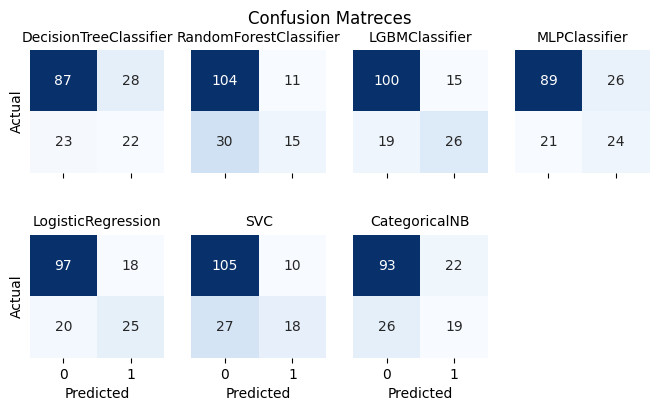

In [37]:
# Make confusion matreces (with cross validation using the train set)

models = [dt, rf, gb, nn,  lr, sv, nb]

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8,4))
fig.suptitle("Confusion Matreces")

for i, (md, ax) in enumerate(zip(models, axes.ravel())):
    cm = confusion_matrix(y_dev, md.predict(X_dev))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted') if i in (4,5,6) else ax.set_xticks([])
    ax.set_ylabel('Actual') if i in (0,4) else ax.set_yticks([])
    ax.set_title(md[-1].__class__.__name__, fontsize=10)
plt.delaxes(axes.ravel()[-1])
plt.subplots_adjust(hspace=0.5)


Some notions:
- Gradient Boosting has the best TPR 
- Gradient Boosting has the least FNR (which is good for F2 metric)


## TODO

- do threshold optimization
- make CM again with the optimized threshes
- compare the sets of the FP misclassifications for the models: same or different saples are getting mislassified by different models? (if diffrenet -> these diverse models wil be useful in eseble)
- get all the samples which are FN by all models, and analyze these samples to find commonalities

- upsample for tree-based
- drop maintanence? job? and add the ratio
- make proper trans pipeline(s)
- select 3-5 promising models: make soft voting calssifier (possibly with all possible combinations of estimators of 2-6 estimators)





# THE CHECKLIST

## Prepare the data
...

3. Encode, dummify categorical features. Maybe "numerize" categorical features with too many categories.

4. Feature engineering, where appropriate:
    - Discretize continuous features.
    - Decompose features (e.g., categorical, date/time, etc.)  SEX
    - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
    - Aggregate features into promising new features.

5. Feature scaling: standardize or normalize features.

## Short-list promising models  
Notes: 
- If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).  
- Once again, try to automate these steps as much as possible.    

1. Train many quick and dirty models from different categories (e.g., linear, naive, Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.  
2. Measure and compare their performance.  
    - For each model, use N-fold cross-validation and compute the mean and standard deviation of their performance. 
3. **Analyze the most significant variables for each algorithm.**
4. Analyze the types of errors the models make.  
    - What data would a human have used to avoid these errors?  
5. Have a quick round of feature selection and engineering.  
6. Have one or two more quick iterations of steps 1-5  
7. Short-list the top 3-5 most promising models, preferring models that **make different types of errors.**  






### Checklist:
https://github.com/ageron/handson-ml3/blob/main/ml-project-checklist.md





In [38]:



# THRESHOLD OPTIMIZATION

"""
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from functools import partial


# Get data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict probabilities
clf = LogisticRegression().fit(X_train, y_train)
probs = clf.predict_proba(X_val)[:, 1]  # Probabilities of class 1

# Try all the thresholds
f2 = partial(fbeta_score, beta=2)
thresholds = np.linspace(0, 1, 100)
f2_scores = [f2(y_val, (probs > thresh).astype(int)) for thresh in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)
print("best threshold:", best_threshold)
print("best f2-Score:", best_f2_score)
""";